# Réseau de neurones from scratch

## Définition des classes principales

Ce notebook implémente un réseau de neurones simple en utilisant NumPy. Les composants clés sont :

- **Parameter** : Conteneur pour les poids et biais apprenables du réseau.
- **Function** : Classe de base pour les opérations (addition, multiplication, activations, perte) et leur différentiation (méthodes `forward` et `backward`).
- **Module** : Classe de base pour les couches et le réseau, gérant les paramètres et les sous-modules.
- **Linear** : Couche linéaire (transformation affine).
- **Layer** : Combine une couche linéaire avec une fonction d'activation.
- **Adam** : Algorithme d'optimisation pour mettre à jour les paramètres.
- **NeuralNetwork** : Le réseau de neurones complet, assemblant les couches.
- **Dataset** : Classe utilitaire pour générer des données synthétiques.
- **LR_Scheduler** : Classe pour ajuster le taux d'apprentissage pendant l'entraînement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Classe `Parameter`

Encapsule les tenseurs (ici, des tableaux NumPy) qui sont les paramètres apprenables du modèle (poids et biais). Elle stocke la valeur du paramètre (`data`) et son gradient (`_grad`), ainsi qu'un indicateur (`_requires_grad`) pour savoir si le gradient doit être calculé pour ce paramètre, ici ce sera toujours le cas.

In [2]:
class Parameter:
    """Stocke les paramètres apprenables et leur gradient."""
    def __init__(self, data, requires_grad=True):
        self._requires_grad = requires_grad # Indique si le gradient doit être calculé
        self._grad = None # Stocke le gradient calculé lors de la rétropropagation
        self.data = data # La valeur actuelle du paramètre (poids ou biais)

### Classe `Module`

Classe de base pour toutes les couches et le réseau lui-même. Elle fournit des fonctionnalités pour enregistrer des sous-modules et des paramètres, facilitant la gestion de structures de réseau complexes. Elle permet également d'appeler directement une instance de module comme une fonction, ce qui exécute sa méthode `forward`.

In [3]:
class Module:
    """Classe de base pour les couches et le réseau."""
    def __init__(self):
        self.modules = {} # Dictionnaire pour stocker les sous-modules (ex: couches dans un réseau)
        self.parameters = [] # Liste pour stocker les paramètres de ce module et de ses sous-modules
        self.fns = [] # Liste temporaire pour stocker les fonctions utilisées lors du forward pass (pour le backward)

    def __call__(self, *args, **kwargs):
        """Permet d'appeler le module comme une fonction, exécutant le forward pass."""
        return self.forward(*args, **kwargs)
    
    def add_module(self, name, module):
        """Ajoute un sous-module (ex: une couche) à ce module."""
        if not isinstance(module, Module):
            raise TypeError("module must be an instance of Module")
        self.modules.update({name: module})
        # Ajoute les paramètres du sous-module à la liste des paramètres du module parent
        self.parameters.extend(module.get_parameters())

    def clear_fns(self):
        """Vide la liste des fonctions utilisées lors du forward pass."""
        self.fns = []

    def register_parameter(self, parameter):
        """Enregistre un paramètre directement dans ce module."""
        self.parameters.append(parameter)

    def register_function(self, fn):
        """Enregistre une fonction utilisée pendant le forward pass (utile pour le backward)."""
        self.fns.append(fn)

    def get_parameters(self):
        """Retourne la liste de tous les paramètres (propres et des sous-modules)."""
        return self.parameters

### Classe `Function`

Classe de base pour toutes les opérations différentiables (couches, activations, fonctions de perte). Chaque fonction doit implémenter :
- `forward`: Calcule la sortie de la fonction.
- `backward`: Calcule le gradient de la perte par rapport à l'entrée de la fonction, en utilisant le gradient de la perte par rapport à la sortie (fourni en argument). C'est l'étape clé de la rétropropagation, basée sur la règle de dérivation en chaîne.

Lors de l'appel (`__call__`), l'entrée et la sortie sont stockées pour être utilisées lors du `backward`.

In [4]:
class Function:
    """Classe de base pour les opérations différentiables."""
    def __init__(self):
        self._input = None # Stocke l'entrée(s) du forward pass
        self._output = None # Stocke la sortie du forward pass
        self._grad_input = None # Stocke le gradient calculé par rapport à l'entrée
        self._grad_output = None # Stocke le gradient reçu de la couche suivante

    def forward(self, *args):
        """Calcule la sortie de la fonction."""
        raise NotImplementedError("forward method not implemented")
    
    def backward(self, *args):
        """Calcule le gradient par rapport à l'entrée."""
        raise NotImplementedError("backward method not implemented")
    
    def __call__(self, *args):
        """Exécute le forward pass et stocke l'entrée/sortie."""
        self._input = args
        self._output = self.forward(*args)
        return self._output

### Théorie Mathématique : Forward et Backward Propagation

#### Notations
Considérons un réseau de neurones feedforward avec $L$ couches.
- $n$: Indice de couche ($n=1, ..., L$). La couche 0 est l'entrée $x$.
- $y^{(n)}$: Vecteur d'activation (sortie) de la couche $n$. $y^{(0)} = x$.
- $z^{(n)}$: Vecteur de pré-activation de la couche $n$.
- $W^{(n)}$: Matrice des poids de la couche $n$. $W_{ij}^{(n)}$ est le poids connectant le neurone $j$ de la couche $n-1$ au neurone $i$ de la couche $n$.
- $b^{(n)}$: Vecteur des biais de la couche $n$.
- $\sigma^{(n)}$: Fonction d'activation de la couche $n$. $\sigma$ sans indice représente une fonction d'activation générique.
- $\mathcal{L}$: Fonction de perte (Loss).
- $N$: Taille du batch.

#### Forward Propagation (Passe Avant)
Le but est de calculer la prédiction $y^{(L)} = y_{pred}$ à partir de l'entrée $x = y^{(0)}$.
Pour chaque couche $n$ de $1$ à $L$:
1.  **Transformation Linéaire**: Calcul de la pré-activation.
    $$ z^{(n)} = W^{(n)} y^{(n-1)} + b^{(n)} $$
    En termes d'indices : $ z_i^{(n)} = \sum_j W_{ij}^{(n)} y_j^{(n-1)} + b_i^{(n)} $
    *   **Code**: Ceci est implémenté dans `Linear.forward`. L'opération $W^{(n)} y^{(n-1)}$ correspond à `Mult()(y_prev, self.weight.data)` et l'addition $+ b^{(n)}$ correspond à `Add()(res_mult, self.bias.data)`. Les instances `Mult` et `Add` sont enregistrées (`register_function`).

2.  **Fonction d'Activation**: Calcul de l'activation.
    $$ y^{(n)} = \sigma^{(n)}(z^{(n)}) $$
    En termes d'indices : $ y_i^{(n)} = \sigma^{(n)}(z_i^{(n)}) $
    *   **Code**: Ceci est implémenté par l'appel à `self.activation(x)` dans `Layer.forward`, où `self.activation` est une instance d'une classe héritant de `Function` (e.g., `Tanh`, `ReLU`). La fonction d'activation enregistre également son entrée $z^{(n)}$ pour le backward pass.
    *   Note: La dernière couche (`Linear` dans `NeuralNetwork`) n'a pas de fonction d'activation dans cette implémentation, donc $y^{(L)} = z^{(L)}$.

3.  **Calcul de la Perte**: Après la dernière couche, on calcule la perte.
    $$ \mathcal{L} = L(y^{(L)}, y_{true}) $$
    *   **Code**: Ceci est fait par `self.loss(x, y)` dans `NeuralNetwork.forward`, où `self.loss` est une instance de `MSELoss`. Elle enregistre $y^{(L)}$ et $y_{true}$.

Le `NeuralNetwork.forward` orchestre ces étapes en appelant séquentiellement les `forward` des `Layer` (qui contiennent `Linear` et `Activation`) et enfin le `forward` de la `MSELoss`.

#### Backward Propagation (Rétropropagation)
Le but est de calculer les gradients de la perte $\mathcal{L}$ par rapport à tous les paramètres ($W^{(n)}$, $b^{(n)}$ pour $n=1..L$) en utilisant la règle de dérivation en chaîne.

On calcule les gradients couche par couche, en partant de la fin.
**Notation de gradient**: $\delta^{(n)} = \frac{\partial \mathcal{L}}{\partial z^{(n)}}$ (gradient de la perte par rapport à la pré-activation de la couche $n$).

1.  **Initialisation (Couche de sortie L)**:
    *   Calculer le gradient de la perte par rapport à la sortie du réseau:
      $$ \frac{\partial \mathcal{L}}{\partial y^{(L)}} $$
      *   **Code**: C'est le point de départ, calculé par `self.loss.backward()`. Pour `MSELoss`, $\frac{\partial \mathcal{L}}{\partial y_i^{(L)}} = 2(y_i^{(L)} - y_{true, i})$. Le code `MSELoss.backward` retourne $2 * (y_{pred} - y_{true})$.
    *   Calculer $\delta^{(L)}$:
      $$ \delta^{(L)} = \frac{\partial \mathcal{L}}{\partial z^{(L)}} = \frac{\partial \mathcal{L}}{\partial y^{(L)}} \odot \sigma^{(L)\prime}(z^{(L)}) $$
      où $\odot$ est la multiplication élément par élément et $\sigma^{(L)\prime}$ est la dérivée de la fonction d'activation de la couche L.
      *   **Code**: Si la dernière couche est `Linear` (pas d'activation $\sigma^{(L)}$), alors $y^{(L)}=z^{(L)}$ et $\sigma^{(L)\prime}=1$, donc $\delta^{(L)} = \frac{\partial \mathcal{L}}{\partial y^{(L)}}$. Le gradient $\frac{\partial \mathcal{L}}{\partial y^{(L)}}$ (retourné par `loss.backward`) est directement passé comme `grad_output` à `self.layers[-1].backward()` (qui est un `Linear.backward`).
      *   Si la dernière couche était un `Layer` avec activation, `Layer.backward` appellerait d'abord `activation.backward(grad_output)` qui calcule $\frac{\partial \mathcal{L}}{\partial y^{(L)}} \odot \sigma^{(L)\prime}(z^{(L)})$.

2.  **Propagation vers l'arrière (Pour n de L à 1)**:
    Supposons que nous ayons calculé $\delta^{(n)} = \frac{\partial \mathcal{L}}{\partial z^{(n)}}$.
    *   **Calcul des gradients des paramètres de la couche n**: 
      $$ \frac{\partial \mathcal{L}}{\partial W^{(n)}} = \delta^{(n)} (y^{(n-1)})^T \frac{1}{N} $$
      $$ \frac{\partial \mathcal{L}}{\partial b^{(n)}} = \sum_{batch} \delta^{(n)} \frac{1}{N}$$
       (Somme ou moyenne sur les exemples du batch)
      *   **Code**: Ceci est calculé dans `Linear.backward`. Le `grad_output` reçu par `Linear.backward` est $\delta^{(n)}$.
          *   `Add.backward(grad_output)` (où `grad_output` est $\delta^{(n)}$) calcule $\frac{\partial \mathcal{L}}{\partial b^{(n)}} = \sum_{batch} \delta^{(n)} \frac{1}{N}$ (variable `db`) et retourne aussi $\delta^{(n)}$ (variable `dx_add`).
          *   `Mult.backward(dx_add)` (où `dx_add` est $\delta^{(n)}$) utilise l'entrée enregistrée $y^{(n-1)}$ pour calculer $\frac{\partial \mathcal{L}}{\partial W^{(n)}} = (y^{(n-1)})^T \delta^{(n)} \frac{1}{N}$ (variable `dw`, après transposition et moyenne sur le batch) et $\frac{\partial \mathcal{L}}{\partial y^{(n-1)}} = \delta^{(n)} (W^{(n)})^T$ (variable `dx`).
          *   Les gradients `dw` et `db` sont stockés dans `self.weight._grad` et `self.bias._grad`.
    *   **Calcul du gradient à propager à la couche n-1**: 
      $$ \frac{\partial \mathcal{L}}{\partial y^{(n-1)}} = (W^{(n)})^T \delta^{(n)} $$
      *   **Code**: C'est le gradient `dx` retourné par `Mult.backward` et ensuite par `Linear.backward`.
    *   **Calcul de $\delta^{(n-1)}$ pour la couche précédente**: 
      $$ \delta^{(n-1)} = \frac{\partial \mathcal{L}}{\partial z^{(n-1)}} = \frac{\partial \mathcal{L}}{\partial y^{(n-1)}} \odot \sigma^{(n-1)\prime}(z^{(n-1)}) $$
      *   **Code**: Le gradient $\frac{\partial \mathcal{L}}{\partial y^{(n-1)}}$ (retourné par `Linear.backward` de la couche $n$) est passé comme `grad_output` à `Layer.backward` de la couche $n-1$.
      *   `Layer.backward` appelle d'abord `activation.backward(grad_output)` qui calcule $\delta^{(n-1)} = \frac{\partial \mathcal{L}}{\partial y^{(n-1)}} \odot \sigma^{(n-1)\prime}(z^{(n-1)})$.
      *   Ce $\delta^{(n-1)}$ est ensuite passé comme `grad_output` à `self.linear.backward` pour calculer les gradients des paramètres $W^{(n-1)}, b^{(n-1)}$ et le gradient $\frac{\partial \mathcal{L}}{\partial y^{(n-2)}}$ à propager.

Le `NeuralNetwork.backward` initie ce processus en appelant `loss.backward()` et propage ensuite le gradient en appelant les `backward` des couches en ordre inverse. Chaque `backward` de `Layer`, `Linear`, `Activation`, `Add`, `Mult` implémente une étape de la règle de chaîne, calculant soit les gradients des paramètres locaux, soit le gradient à propager à l'étape précédente, soit les deux.

### Implémentations de `Function`

Implémentations spécifiques pour différentes opérations : addition, multiplication matricielle, fonctions d'activation (ReLU, Identity, Arctan, Tanh) et fonction de perte (MSELoss).

**Principe du `backward` (Rétropropagation)**

La méthode `backward(grad_output)` reçoit `grad_output`, qui est le gradient de la perte finale par rapport à la *sortie* de cette fonction (`dLoss / dOutput`). Son objectif est de calculer le gradient de la perte par rapport à l'*entrée* de cette fonction (`dLoss / dInput`).

Selon la règle de dérivation en chaîne :
`dLoss / dInput = (dLoss / dOutput) * (dOutput / dInput)`

Donc, chaque méthode `backward` doit :
1. Calculer la dérivée locale de la sortie par rapport à l'entrée (`dOutput / dInput`), en utilisant potentiellement les valeurs d'entrée stockées (`self._input`).
2. Multiplier cette dérivée locale par le gradient reçu (`grad_output`).
3. Retourner le résultat (`dLoss / dInput`), qui sera passé comme `grad_output` à la fonction précédente dans le calcul.

In [5]:
class Add(Function):
    """Addition élément par élément."""
    def forward(self, x, y):
        # y est souvent un biais, x les activations. Leurs dernières dimensions doivent correspondre.
        assert x.shape[-1] == y.shape[-1], f"x and y must have the same shape but got {x.shape[-1]} and {y.shape[-1]}"
        return x + y

    def backward(self, grad_output):
        """ Calcule dLoss/dx et dLoss/dy. """
        # dOutput/dx = 1, dOutput/dy = 1 (pour chaque élément)
        # dLoss/dx = dLoss/dOutput * dOutput/dx = grad_output * 1
        # dLoss/dy = dLoss/dOutput * dOutput/dy = grad_output * 1
        # Pour le biais (y), on somme les gradients sur la dimension du batch (axis=0)
        # car le même biais est ajouté à chaque exemple du batch.
        # On divise par la taille du batch pour obtenir une moyenne.
        return grad_output, grad_output.sum(axis=0) / grad_output.shape[0]
    
class Mult(Function):
    """Multiplication matricielle."""
    def forward(self, x, y):
        # x: (batch_size, in_features), y: (in_features, out_features)
        assert x.shape[-1] == y.shape[-2], f"impossible to compute matmult due to wrong shape (got {x.shape} and {y.shape})"
        self._input = (x, y) # Stocker x et y pour le backward
        output = x @ y
        return output
    
    def backward(self, grad_output):
        """ Calcule dLoss/dx et dLoss/dy (où y sont les poids). """
        # grad_output: (batch_size, out_features)
        x, y = self._input # x: (batch_size, in_features), y: (in_features, out_features)
        
        # Règle de dérivation matricielle:
        # d(X@Y)/dX = grad_output @ Y.T
        # d(X@Y)/dY = X.T @ grad_output
        
        # dLoss/dy = (dLoss/dOutput) * (dOutput/dy) = X.T @ grad_output
        # On moyenne sur le batch pour le gradient des poids (y)
        grad_y = x.T @ grad_output / x.shape[0]
        
        # dLoss/dx = (dLoss/dOutput) * (dOutput/dx) = grad_output @ Y.T
        grad_x = grad_output @ y.T
        
        return grad_x, grad_y
    
class ReLU(Function):
    """Fonction d'activation ReLU (Rectified Linear Unit)."""
    def __init__(self, eps=0): # eps permet d'implémenter Leaky ReLU
        super().__init__()
        self.eps = eps

    def forward(self, x):
        self._input = x # Stocker x pour le backward
        return np.maximum(self.eps * x, x)

    def backward(self, grad_output):
        """ Calcule dLoss/dx. """
        x = self._input
        # dOutput/dx = 1 si x > 0, sinon eps
        # dLoss/dx = dLoss/dOutput * dOutput/dx
        grad_input = np.where(x > 0, grad_output, self.eps * grad_output)
        return grad_input
    
class Identity(Function):
    """Fonction identité (pas d'activation)."""
    def forward(self, x):
        self._input = x
        return x

    def backward(self, grad_output):
        """ Calcule dLoss/dx. """
        # dOutput/dx = 1
        # dLoss/dx = dLoss/dOutput * 1
        return grad_output    

class Arctan(Function):
    """Fonction d'activation Arctangente."""
    def forward(self, x):
        self._input = x
        return np.arctan(x)

    def backward(self, grad_output):
        """ Calcule dLoss/dx. """
        x = self._input
        # d(arctan(x))/dx = 1 / (1 + x**2)
        # dLoss/dx = dLoss/dOutput * (1 / (1 + x**2))
        grad_input = grad_output / (1 + x**2)
        return grad_input
    
class Tanh(Function):
    """Fonction d'activation Tangente Hyperbolique."""
    def forward(self, x):
        self._input = x
        return np.tanh(x)

    def backward(self, grad_output):
        """ Calcule dLoss/dx. """
        x = self._input
        # d(tanh(x))/dx = 1 - tanh(x)**2
        # dLoss/dx = dLoss/dOutput * (1 - tanh(x)**2)
        grad_input = grad_output * (1 - np.tanh(x)**2)
        return grad_input
    
class MSELoss(Function):
    """Fonction de perte : Erreur Quadratique Moyenne (Mean Squared Error)."""
    def forward(self, y_pred, y_true):
        # y_pred: prédictions du modèle, y_true: vraies valeurs
        self._input = (y_pred, y_true)
        # Calcule la moyenne des carrés des différences
        return np.mean((y_pred - y_true) ** 2)

    def backward(self, grad_output=1.0): # grad_output est souvent 1 pour la fonction de perte
        """ Calcule dLoss/dy_pred. """
        y_pred, y_true = self._input
        # Loss = (1/N) * sum((y_pred - y_true)**2)
        # dLoss/dy_pred = (1/N) * sum(2 * (y_pred - y_true))
        # Le calcul de la moyenne (1/N) est implicitement géré par la moyenne effectuée
        # dans le backward de la multiplication matricielle lors du calcul du gradient des poids.
        # Ici, on retourne le gradient avant la moyenne sur le batch.
        grad_input = (2 * (y_pred - y_true))
        # On multiplie par grad_output (qui est généralement 1.0 ici)
        return grad_input * grad_output

### Classe `Linear`

Implémente une couche linéaire (ou dense) : `output = input @ weight + bias`.

- **Forward**: Effectue la multiplication matricielle et ajoute le biais (s'il existe). Enregistre les fonctions `Mult` et `Add` utilisées.
- **Backward**: Reçoit le gradient de la couche suivante (`grad_output`). Utilise les fonctions `Add` et `Mult` enregistrées (dans l'ordre inverse) pour propager le gradient vers l'entrée (`dx`) et calculer les gradients des poids (`dw`) et du biais (`db`). Ces gradients sont stockés dans les objets `Parameter` correspondants.

In [6]:
class Linear(Module):
    """Couche linéaire: y = x @ W + b."""
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Initialisation des poids (distribution normale faible)
        self.weight = Parameter(np.random.normal(0, 0.02, size=(in_features, out_features)))
        self.register_parameter(self.weight)
        if bias:
            # Initialisation du biais
            self.bias = Parameter(np.random.normal(0, 0.02, size=(out_features)))
            self.register_parameter(self.bias)
        else:
            self.bias = None
    
    def forward(self, x):
        # x: (batch_size, in_features)
        # weight: (in_features, out_features)
        # bias: (out_features,)
        # output: (batch_size, out_features)
        if self.bias is not None:
            # 1. Multiplication: x @ weight
            m = Mult()
            self.register_function(m) # Enregistrer pour le backward
            res = m(x, self.weight.data)
            # 2. Addition: res + bias
            a = Add()
            self.register_function(a) # Enregistrer pour le backward
            res = a(res, self.bias.data)
            return res
        else:
            # Seulement multiplication si pas de biais
            m = Mult()
            self.register_function(m)
            res = m(x, self.weight.data)
            return res
        
    def backward(self, grad_output):
        """ Rétropropagation à travers la couche linéaire. """
        if self.bias is not None:
            # 1. Backward de l'addition (a)
            # Reçoit grad_output (dLoss/dOutput_Add)
            # Retourne dLoss/dInput_Add (gradient avant l'addition) et dLoss/dBias
            dx_add, db = self.fns[-1].backward(grad_output) # self.fns[-1] est 'a'
            # 2. Backward de la multiplication (m)
            # Reçoit dx_add (dLoss/dOutput_Mult)
            # Retourne dLoss/dInput_Mult (gradient avant la multiplication) et dLoss/dWeight
            dx, dw = self.fns[-2].backward(dx_add) # self.fns[-2] est 'm'
            # Stocker les gradients calculés dans les paramètres
            self.weight._grad = dw
            self.bias._grad = db
            self.clear_fns() # Nettoyer les fonctions enregistrées
            return dx # Retourner le gradient par rapport à l'entrée de la couche linéaire
        else:
            # Seulement backward de la multiplication si pas de biais
            dx, dw = self.fns[-1].backward(grad_output) # self.fns[-1] est 'm'
            self.weight._grad = dw
            self.clear_fns()
            return dx

### Classe `Layer`

Combine une couche `Linear` suivie d'une fonction d'activation (`Function`).

- **Forward**: Applique d'abord la couche linéaire, puis la fonction d'activation.
- **Backward**: Applique d'abord le `backward` de la fonction d'activation au gradient reçu, puis passe le résultat au `backward` de la couche linéaire.

In [7]:
class Layer(Module):
    """Combine une couche linéaire et une fonction d'activation."""
    def __init__(self, in_features, out_features, activation=None):
        super().__init__()
        self.linear = Linear(in_features, out_features)
        # Utilise ReLU par défaut si aucune activation n'est fournie
        self.activation = ReLU() if activation is None else activation
        # Enregistre la couche linéaire comme sous-module
        self.add_module('linear', self.linear)

    def forward(self, x):
        """ Passe avant : linéaire puis activation. """
        x = self.linear.forward(x)
        if self.activation is not None:
            # Applique l'activation (qui enregistre aussi l'entrée/sortie)
            x = self.activation(x)
        return x
    
    def backward(self, grad_output):
        """ Passe arrière : activation puis linéaire. """
        if self.activation is not None:
            # 1. Backward de l'activation
            # Reçoit grad_output (dLoss/dOutput_Activation)
            # Retourne dLoss/dInput_Activation
            grad_output = self.activation.backward(grad_output)
        # 2. Backward de la couche linéaire
        # Reçoit le gradient après l'activation (dLoss/dOutput_Linear)
        # Retourne dLoss/dInput_Linear
        dx = self.linear.backward(grad_output)
        return dx

### Classe `Adam`

Implémente l'optimiseur Adam (Adaptive Moment Estimation). C'est un algorithme d'optimisation stochastique populaire qui calcule des taux d'apprentissage adaptatifs pour chaque paramètre.

Il maintient deux moyennes mobiles exponentielles :
1. `m`: Moyenne des gradients passés (moment d'ordre 1).
2. `v`: Moyenne des carrés des gradients passés (moment d'ordre 2).

La méthode `step` met à jour les paramètres du modèle en utilisant ces moyennes mobiles, après correction de biais, pour adapter le taux d'apprentissage.

In [8]:
class Adam:
    """Optimiseur Adam."""
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params # Liste des Parameter à optimiser
        self.lr = lr # Taux d'apprentissage
        self.beta1 = beta1 # Facteur d'oubli pour le moment d'ordre 1 (m)
        self.beta2 = beta2 # Facteur d'oubli pour le moment d'ordre 2 (v)
        self.eps = eps # Petit terme pour éviter la division par zéro
        # Initialise les moments m et v avec des zéros de même forme que les paramètres
        self.m = [np.zeros_like(p.data) for p in params]
        self.v = [np.zeros_like(p.data) for p in params]
        self.t = 0 # Compteur de pas (itérations)

    def step(self):
        """Effectue une étape d'optimisation (mise à jour des paramètres)."""
        self.t += 1
        if len(self.params) == 0:
            raise ValueError("No parameters to optimize")
        
        for i, p in enumerate(self.params):
            if p._requires_grad:
                # Vérifie si un gradient a été calculé pour ce paramètre
                if p._grad is None:
                    # print(f"Warning: Gradient for parameter {i} is None. Skipping update.")
                    continue # Passer au paramètre suivant si pas de gradient
                if (p._grad == 0).all():
                    # print(f"Warning: Gradient for parameter {i} is zero. Skipping update.")
                    continue # Passer si le gradient est nul
                    
                grad = p._grad # Gradient calculé lors du backward pass
                
                # Mise à jour des moyennes mobiles exponentielles
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
                
                # Correction du biais des moments (surtout important au début)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                
                # Calcul de la mise à jour du paramètre
                update = self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
                
                # Vérification de forme (sécurité)
                assert p.data.shape == update.shape, f"Shape mismatch: {p.data.shape} vs {update.shape}"
                
                # Appliquer la mise à jour (descente de gradient)
                p.data = p.data - update
                
                # Réinitialiser le gradient pour le prochain cycle forward/backward
                p._grad = None

### Classe `NeuralNetwork`

Assemble les couches (`Layer` et `Linear`) pour former le réseau complet.

- **Initialisation**: Crée les couches (une couche d'entrée, plusieurs couches cachées, une couche de sortie) et les enregistre comme sous-modules. Initialise également la fonction de perte.
- **Forward**: Fait passer l'entrée `x` séquentiellement à travers toutes les couches. Si `y` (la cible) est fournie, calcule et retourne également la perte.
- **Backward**: Initialise la rétropropagation en appelant le `backward` de la fonction de perte. Ensuite, propage le gradient à travers les couches en ordre inverse, de la sortie vers l'entrée, en appelant le `backward` de chaque couche.

In [9]:
class NeuralNetwork(Module):
    """Le réseau de neurones complet."""
    def __init__(self, nb_layers=4, in_features=1, out_features=1, hidden_features=16, activation=Arctan()):
        super().__init__()
        self.layers = []
        self.loss = MSELoss() # Utilise MSE comme fonction de perte
        self.register_function(self.loss) # Enregistre la fonction de perte
        
        # Couche d'entrée (Layer = Linear + Activation)
        self.layers.append(Layer(in_features, hidden_features, activation))
        # Couches cachées (Layer = Linear + Activation)
        for _ in range(nb_layers):
            layer = Layer(hidden_features, hidden_features, activation)
            self.layers.append(layer)
        # Couche de sortie (Linear seulement, pas d'activation finale ici)
        self.layers.append(Linear(hidden_features, out_features))
        
        # Enregistre chaque couche comme sous-module
        for i, layer in enumerate(self.layers):
            self.add_module(f'layer_{i}', layer)

    def forward(self, x, y=None):
        """ Passe avant à travers tout le réseau. """
        # Propagation à travers les couches
        for layer in self.layers:
            x = layer.forward(x)
        
        # Si les cibles y sont fournies, calculer la perte
        if y is not None:
            loss = self.loss(x, y) # x est maintenant la prédiction finale y_pred
            return x, loss
        return x, None # Retourne seulement la prédiction si pas de cible

    def __call__(self, *args, **kwds):
        # Assure que l'appel direct exécute le forward défini ici
        return super().__call__(*args, **kwds)
    
    def backward(self):
        """ Passe arrière à travers tout le réseau. """
        # 1. Démarrer la rétropropagation à partir de la fonction de perte
        # Calcule dLoss/dy_pred
        grad_output = self.loss.backward()
        
        # 2. Propager le gradient en arrière à travers les couches (ordre inverse)
        for i, layer in enumerate(reversed(self.layers)):
            # Passe le gradient reçu à la méthode backward de la couche
            # La méthode backward de la couche calcule les gradients de ses paramètres
            # et retourne le gradient par rapport à son entrée.
            grad_output = layer.backward(grad_output)
            
        # Le gradient final retourné est dLoss/dx (gradient par rapport à l'entrée du réseau)
        # mais les gradients importants (poids/biais) ont été stockés dans les Parameters
        return grad_output

### Test simple (débugging)

Vérification du fonctionnement des passes `forward` et `backward` ainsi que de l'optimiseur `Adam` sur un petit exemple avec des poids et des données définis manuellement.

In [10]:
# Création d'un petit réseau (0 couche cachée => 1 Layer + 1 Linear)
nn = NeuralNetwork(nb_layers=0, in_features=2, out_features=1, hidden_features=2)

# Accès aux couches pour définir les poids manuellement
layer0 = nn.layers[0] # Première couche (Layer = Linear + Activation)
linear0 = layer0.linear # Couche linéaire dans layer0
layer1 = nn.layers[1] # Deuxième couche (Linear de sortie)

# Définition manuelle des poids et biais
linear0.weight.data = np.array([[1., 2.], [3., 4.]]) # (in=2, hidden=2)
linear0.bias.data = np.array([1., 2.]) # (hidden=2)
layer1.weight.data = np.array([[1.], [2.]]) # (hidden=2, out=1)
layer1.bias.data = np.array([-1.]) # (out=1)

# Données d'entrée et cibles (batch de 3 exemples)
x = np.array([[2., 3.], [3., 4.], [4., 5.]]) # (batch=3, in=2)
y_hat = np.array([[3.], [4.], [5.]]) # (batch=3, out=1)

# Initialisation de l'optimiseur avec les paramètres du réseau
lin_adam = Adam(nn.get_parameters(), lr=0.01)

# --- Forward Pass ---
y, l = nn(x, y_hat) # Calcul des prédictions (y) et de la perte (l)
print(f"Input:\n{x}")
print(f"Weight 0:\n{linear0.weight.data}")
print(f"Bias 0:\n{linear0.bias.data}")
print(f"Weight 1:\n{layer1.weight.data}")
print(f"Bias 1:\n{layer1.bias.data}")
print(f"Output (Predictions):\n{y}")
print(f"Target:\n{y_hat}")
print(f"Loss: {l}")

# --- Backward Pass ---
dx = nn.backward() # Calcule les gradients (stockés dans les Parameter)
print(f"Gradient w.r.t. input (dx):\n{dx}")
print(f"Weight 0 grad:\n{linear0.weight._grad}")
print(f"Bias 0 grad:\n{linear0.bias._grad}")
print(f"Weight 1 grad:\n{layer1.weight._grad}")
print(f"Bias 1 grad:\n{layer1.bias._grad}")

# --- Optimizer Step ---
lin_adam.step() # Met à jour les poids et biais en utilisant les gradients calculés
print("--- After Adam Step ---")
print(f"Updated Weight 0:\n{linear0.weight.data}")
print(f"Updated Bias 0:\n{linear0.bias.data}")
print(f"Updated Weight 1:\n{layer1.weight.data}")
print(f"Updated Bias 1:\n{layer1.bias.data}")

Input:
[[2. 3.]
 [3. 4.]
 [4. 5.]]
Weight 0:
[[1. 2.]
 [3. 4.]]
Bias 0:
[1. 2.]
Weight 1:
[[1.]
 [2.]]
Bias 1:
[-1.]
Output (Predictions):
[[3.51825074]
 [3.56668501]
 [3.59578859]]
Target:
[[3.]
 [4.]
 [5.]]
Loss: 0.809385127304723
Gradient w.r.t. input (dx):
[[ 0.01990523  0.04695874]
 [-0.00937993 -0.02213197]
 [-0.01947157 -0.0459467 ]]
Weight 0 grad:
[[-0.00794464 -0.00706362]
 [-0.00902043 -0.00801677]]
Bias 0 grad:
[-0.00107579 -0.00095315]
Weight 1 grad:
[[-1.34546814]
 [-1.35749428]]
Bias 1 grad:
[-0.8795171]
--- After Adam Step ---
Updated Weight 0:
[[1.00999999 2.00999999]
 [3.00999999 4.00999999]]
Updated Bias 0:
[1.00999991 2.0099999 ]
Updated Weight 1:
[[1.01]
 [2.01]]
Updated Bias 1:
[-0.99]


### Boucle d'entraînement simple

Exécute plusieurs étapes d'entraînement (forward, backward, optimizer step) sur le même petit jeu de données pour observer la convergence de la perte.

In [11]:
print("--- Training Loop --- ")
for i in range(100): # Nombre réduit d'itérations pour l'exemple
    # Forward pass: Calculer prédictions et perte
    y, l = nn(x, y_hat)
    # Backward pass: Calculer les gradients
    dx = nn.backward()
    if i % 20 == 0: # Afficher la perte toutes les 20 itérations
        print(f"Iteration {i}, Loss: {l}")
    # Mise à jour des paramètres
    lin_adam.step()

# Vérifier les prédictions après entraînement
print("--- Predictions After Training ---")
final_y, _ = nn(x)
print(f"Final Output (Predictions):\n{final_y}")
print(f"Target:\n{y_hat}")

--- Training Loop --- 
Iteration 0, Loss: 0.7748949895871119
Iteration 20, Loss: 0.6244611787545358
Iteration 40, Loss: 0.6094297361069584
Iteration 60, Loss: 0.6023206775222462
Iteration 80, Loss: 0.5939425034062823
--- Predictions After Training ---
Final Output (Predictions):
[[3.92836028]
 [4.0118833 ]
 [4.06141396]]
Target:
[[3.]
 [4.]
 [5.]]


### Classe `Dataset`

Génère un jeu de données synthétiques pour entraîner le réseau à approximer la fonction sinus. Les données sont divisées en ensembles d'entraînement et d'évaluation, et structurées en batches.

In [12]:
class Dataset:
    """Génère des données synthétiques (x, sin(x)) et les divise en train/eval."""
    def __init__(self, min_max_value, nb_data=1000, eval_ratio=0.1, batch_size=32):
        self.min_max_value = min_max_value # Plage des valeurs de x
        self.nb_data = nb_data # Nombre total de points de données (avant batching)
        self.eval_ratio = eval_ratio # Proportion des données pour l'évaluation
        self.batch_size = batch_size
        
        # Calcule le nombre de batches
        nb_batches = nb_data // batch_size
        
        # Génère x uniformément entre -min_max_value et +min_max_value
        # Forme: (nb_batches, batch_size, 1) pour correspondre à l'entrée du réseau
        x_ = np.random.uniform(-min_max_value, min_max_value, size=(nb_batches, batch_size, 1))
        # Calcule y = sin(x)
        y_ = np.sin(x_)
        
        # Divise en ensembles d'entraînement et d'évaluation (par batch)
        self.nb_eval = int(nb_batches * eval_ratio)
        self.nb_train = nb_batches - self.nb_eval
        
        self.x_train = x_[:self.nb_train, :, :]
        self.y_train = y_[:self.nb_train, :, :]
        self.x_eval = x_[self.nb_train:, :, :]
        self.y_eval = y_[self.nb_train:, :, :]
        print(f"Dataset created: {self.nb_train} training batches, {self.nb_eval} evaluation batches.")

    def get_train_data(self):
        """Retourne les données d'entraînement (x, y)."""
        return self.x_train, self.y_train
    
    def get_eval_data(self):
        """Retourne les données d'évaluation (x, y)."""
        return self.x_eval, self.y_eval
    
    def eval_len(self):
        """Retourne le nombre de batches d'évaluation."""
        return self.nb_eval
    
    def train_len(self):
        """Retourne le nombre de batches d'entraînement."""
        return self.nb_train

### Classe `LR_Scheduler`

Implémente une stratégie simple de réduction du taux d'apprentissage (learning rate decay). Ici, une décroissance exponentielle est utilisée pendant un nombre défini d'étapes, après quoi le taux d'apprentissage reste fixe à une valeur minimale.

In [26]:
class LR_Scheduler:
    """Planificateur de taux d'apprentissage (décroissance exponentielle)."""
    def __init__(self, optimizer, start_value=0.1, end_value=0.01, nb_steps=1000):
        self.optimizer = optimizer # L'optimiseur dont le lr doit être ajusté
        self.start_value = start_value # Taux d'apprentissage initial
        self.end_value = end_value # Taux d'apprentissage final (plancher)
        self.nb_steps = nb_steps # Nombre d'étapes sur lesquelles la décroissance s'applique
        self.current_step = 0

    def step(self):
        """Met à jour le taux d'apprentissage de l'optimiseur."""
        if self.current_step < self.nb_steps:
            # Calcul du lr avec décroissance exponentielle
            # Le facteur -5 contrôle la vitesse de décroissance
            lr = self.start_value * np.exp(-4 * self.current_step / self.nb_steps)
            # Assure que le lr ne descend pas en dessous de end_value pendant la décroissance
            self.optimizer.lr = max(lr, self.end_value)
            self.current_step += 1
        else:
            # Une fois les nb_steps atteints, fixe le lr à end_value
            self.optimizer.lr = self.end_value

### Initialisation du Modèle et de l'Optimiseur

Création de l'instance du réseau de neurones avec les hyperparamètres souhaités (nombre de couches, taille des couches, fonction d'activation) et initialisation de l'optimiseur Adam avec les paramètres du modèle.

In [27]:
# Hyperparamètres du modèle
hidden_features = 128
nb_hidden_layers = 2
activation_fn = Tanh() # Utilisation de Tanh comme activation

# Création du modèle
model = NeuralNetwork(nb_layers=nb_hidden_layers, 
                      in_features=1, 
                      out_features=1, 
                      hidden_features=hidden_features, 
                      activation=activation_fn)

# Création de l'optimiseur
initial_lr = 0.02
adam = Adam(model.get_parameters(), lr=initial_lr)

# Nombre total de points de données à générer
nb_data_points = int(5*1e4) 

### Initialisation du Dataset et du Scheduler

Configuration des paramètres pour la génération des données (plage, taille de batch) et création de l'instance `Dataset`. Création du planificateur de taux d'apprentissage (`LR_Scheduler`) en le liant à l'optimiseur `Adam`.

In [28]:
# Paramètres du dataset et de l'entraînement
min_max_value = 10 # Plage des données x: [-10, 10]
batch_size = 64
nb_epochs = 10
eval_ratio = 0.1

# Création du dataset
dataset = Dataset(min_max_value, nb_data=nb_data_points, eval_ratio=eval_ratio, batch_size=batch_size)

# Configuration et création du scheduler
final_lr = 1e-7
total_training_steps = dataset.train_len() * nb_epochs
scheduler = LR_Scheduler(adam, start_value=initial_lr, end_value=final_lr, nb_steps=total_training_steps)

Dataset created: 703 training batches, 78 evaluation batches.


### Boucle d'Entraînement Principale

Itère sur les époques et les batches de données d'entraînement.
Pour chaque batch :
1. **Normalisation**: Met à l'échelle les données d'entrée `x` (ici, division par `min_max_value`). C'est souvent utile pour la stabilité de l'entraînement.
2. **Forward Pass**: Calcule les prédictions et la perte.
3. **Backward Pass**: Calcule les gradients.
4. **Optimizer Step**: Met à jour les paramètres du modèle.
5. **Scheduler Step**: Met à jour le taux d'apprentissage.
6. **Logging**: Affiche périodiquement la perte.

Après chaque époque, une évaluation est effectuée sur l'ensemble de données d'évaluation pour surveiller la performance du modèle sur des données non vues pendant l'entraînement.

In [29]:
logging_loss_sum = 0
logging_step_interval = 200 # Afficher la perte tous les 200 pas
global_step = 0

def normalize(x, max_val):
    """ Normalise les données d'entrée. """
    # Simple mise à l'échelle dans ce cas
    return x / max_val

def evaluate(model, dataset, max_val):
    """ Évalue le modèle sur l'ensemble d'évaluation. """
    eval_log_loss = 0
    nb_eval_batches = dataset.eval_len()
    if nb_eval_batches == 0:
        print("No evaluation data.")
        return
        
    # Itérer sur les batches d'évaluation
    for x_eval, y_eval in zip(*dataset.get_eval_data()):
        x_eval_norm = normalize(x_eval, max_val)
        # Obtenir la perte sans calculer les gradients
        _, loss = model(x_eval_norm, y_eval) 
        eval_log_loss += loss.item() # Utiliser .item() pour obtenir la valeur scalaire
    # Afficher la perte moyenne sur l'ensemble d'évaluation
    print(f"--- Evaluation Loss: {eval_log_loss / nb_eval_batches:.5f} ---")
    
# Boucle sur les époques
for epoch in range(nb_epochs):
    print(f"=== Starting Epoch {epoch+1}/{nb_epochs} ===")
    # Boucle sur les batches d'entraînement
    for idx, (x_batch, y_batch) in enumerate(zip(*dataset.get_train_data())):
        # 1. Normaliser l'entrée
        x_batch_norm = normalize(x_batch, min_max_value)
        
        # 2. Forward pass: obtenir prédictions et perte
        _, loss = model(x_batch_norm, y_batch)
        
        # 3. Backward pass: calculer les gradients
        model.backward()
        
        # 4. Mise à jour des paramètres par l'optimiseur
        adam.step()
        
        # 5. Mise à jour du taux d'apprentissage
        scheduler.step()
        
        # 6. Logging
        logging_loss_sum += loss.item()
        global_step += 1
        if global_step % logging_step_interval == 0:
            avg_loss = logging_loss_sum / logging_step_interval
            print(f"Epoch {epoch+1}, Step {global_step}: Avg Loss = {avg_loss:.3e}, LR = {adam.lr:.3e}")
            logging_loss_sum = 0 # Réinitialiser la somme pour la prochaine période
            
    # Évaluation à la fin de chaque époque
    evaluate(model, dataset, min_max_value)

=== Starting Epoch 1/10 ===
Epoch 1, Step 200: Avg Loss = 4.745e-01, LR = 1.786e-02
Epoch 1, Step 200: Avg Loss = 4.745e-01, LR = 1.786e-02
Epoch 1, Step 400: Avg Loss = 4.758e-01, LR = 1.594e-02
Epoch 1, Step 400: Avg Loss = 4.758e-01, LR = 1.594e-02
Epoch 1, Step 600: Avg Loss = 4.664e-01, LR = 1.422e-02
Epoch 1, Step 600: Avg Loss = 4.664e-01, LR = 1.422e-02
--- Evaluation Loss: 0.47498 ---
=== Starting Epoch 2/10 ===
--- Evaluation Loss: 0.47498 ---
=== Starting Epoch 2/10 ===
Epoch 2, Step 800: Avg Loss = 4.697e-01, LR = 1.269e-02
Epoch 2, Step 800: Avg Loss = 4.697e-01, LR = 1.269e-02
Epoch 2, Step 1000: Avg Loss = 4.667e-01, LR = 1.133e-02
Epoch 2, Step 1000: Avg Loss = 4.667e-01, LR = 1.133e-02
Epoch 2, Step 1200: Avg Loss = 4.681e-01, LR = 1.011e-02
Epoch 2, Step 1200: Avg Loss = 4.681e-01, LR = 1.011e-02
Epoch 2, Step 1400: Avg Loss = 4.615e-01, LR = 9.022e-03
--- Evaluation Loss: 0.46723 ---
=== Starting Epoch 3/10 ===
Epoch 2, Step 1400: Avg Loss = 4.615e-01, LR = 9.022e-03

### Visualisation des Résultats

Génère un ensemble de points `x` sur la plage d'intérêt, les normalise, puis utilise le modèle entraîné pour prédire les valeurs `y` correspondantes. Enfin, trace les prédictions du modèle par rapport à la vraie fonction sinus pour visualiser la qualité de l'approximation apprise.

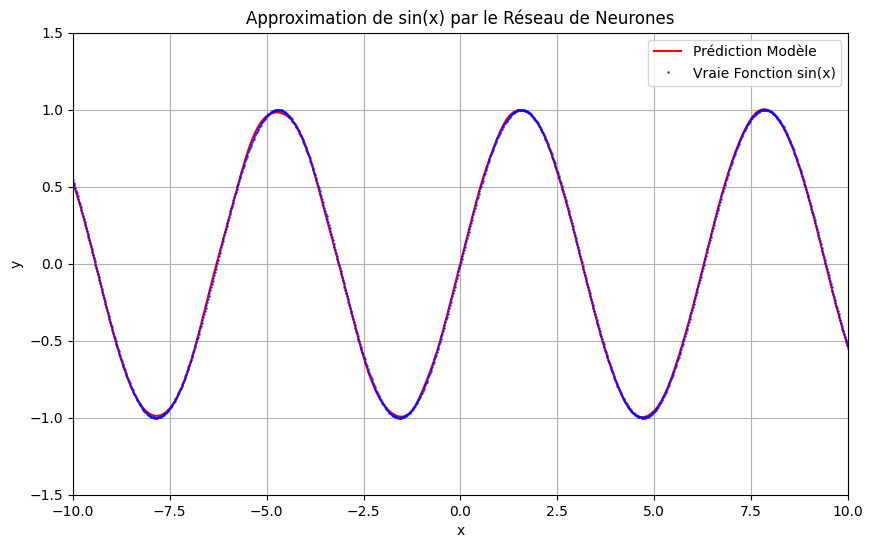

In [30]:
# Générer des points x pour le tracé
x_plot = np.linspace(-min_max_value, min_max_value, 1000)
x_plot_reshaped = x_plot.reshape(-1, 1) # Mettre en forme pour le modèle (N, 1)

# Normaliser les points x
x_plot_norm = normalize(x_plot_reshaped, min_max_value)

# Obtenir les prédictions du modèle (sans calculer la perte ni les gradients)
y_model_pred, _ = model(x_plot_norm)

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_model_pred, label="Prédiction Modèle", color='red')
plt.plot(x_plot, np.sin(x_plot), '.', label="Vraie Fonction sin(x)", markersize=2, color='blue', alpha=0.6)
plt.title("Approximation de sin(x) par le Réseau de Neurones")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-min_max_value, min_max_value)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()

### Conclusion et Discussion

Ce notebook a présenté une implémentation d'un réseau de neurones simple "from scratch" en utilisant NumPy. Nous avons couvert les concepts fondamentaux suivants :

1.  **Structure Modulaire**: L'utilisation des classes `Module`, `Layer`, et `Linear` permet de construire des réseaux de manière flexible et organisée, similaire aux frameworks modernes comme PyTorch ou TensorFlow.
2.  **Graphe de Calcul Dynamique (implicite)**: Bien que non explicite comme dans PyTorch, l'enregistrement des fonctions (`Add`, `Mult`, activations) lors du `forward pass` et leur utilisation lors du `backward pass` simule un graphe de calcul dynamique. Chaque opération stocke les informations nécessaires (entrées) pour calculer les gradients locaux.
3.  **Autodifférentiation (Backward Propagation)**: La classe `Function` et ses implémentations spécifiques (`Add`, `Mult`, `ReLU`, `Tanh`, `MSELoss`, etc.) sont au cœur de la rétropropagation. Chaque fonction implémente sa propre règle de dérivation (`backward`), permettant de calculer les gradients par rapport à ses entrées en utilisant le gradient reçu de l'opération suivante (règle de chaîne).
4.  **Optimisation**: L'implémentation de l'optimiseur `Adam` montre comment les gradients calculés lors de la rétropropagation sont utilisés pour mettre à jour les paramètres apprenables (`Parameter`) du réseau.
5.  **Entraînement**: La boucle d'entraînement standard (forward, backward, optimizer step) a été mise en œuvre, incluant la gestion des données par batch, la normalisation, et l'ajustement du taux d'apprentissage (`LR_Scheduler`).

**Discussion Théorique vs Implémentation**

- La section théorique a détaillé les équations mathématiques de la forward et backward propagation. Le code implémente directement ces équations :
    - `Linear.forward` calcule $z^{(n)} = W^{(n)} y^{(n-1)} + b^{(n)}$ en utilisant `Mult` et `Add`.
    - `Layer.forward` applique ensuite l'activation $y^{(n)} = \sigma^{(n)}(z^{(n)})$.
    - `MSELoss.forward` calcule $\mathcal{L}$.
    - `MSELoss.backward` calcule $\frac{\partial \mathcal{L}}{\partial y^{(L)}}$.
    - `Activation.backward` calcule $\delta = \frac{\partial \mathcal{L}}{\partial y} \odot \sigma'(z)$.
    - `Linear.backward` utilise les `backward` de `Add` et `Mult` pour calculer $\frac{\partial \mathcal{L}}{\partial W^{(n)}}$, $\frac{\partial \mathcal{L}}{\partial b^{(n)}}$ et $\frac{\partial \mathcal{L}}{\partial y^{(n-1)}}$. La division par $N$ (taille du batch) pour les gradients des poids et biais est effectuée dans `Mult.backward` et `Add.backward` respectivement.
- La gestion des dimensions (batch, features) est cruciale et doit être cohérente entre les opérations matricielles (`@`) et les opérations élément par élément (`+`, `*`, activations).
- L'initialisation des poids et l'utilisation d'un scheduler de taux d'apprentissage sont des aspects pratiques importants pour la convergence de l'entraînement.

**Limitations et Pistes d'Amélioration**

- **Efficacité**: L'implémentation NumPy est beaucoup moins efficace que les frameworks optimisés qui utilisent des backends C++/CUDA.

- **Hyperparamètres**: La taille du batch, le taux d'apprentissage, le nombre d'époques, et la structure du réseau (nombre de couches et neurones) sont des hyperparamètres cruciaux. Leur choix a un impact significatif sur la convergence et la performance du modèle. Parfois un simple changement du nombre de neurones dans une couche cachée peut faire la différence entre un modèle qui converge et un modèle qui ne converge pas.
- **Fonctions d'activation**: D'autres fonctions d'activation (ReLU, Leaky ReLU, etc.) pourraient être ajoutées pour explorer leur impact sur l'entraînement.